# Homework 3: Question 2

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import AdamW, GPT2LMHeadModel, GPT2Tokenizer
from utils.data_loader_gen import process_data, read_data
from utils.evaluate_gen import evaluate_model
from utils.zero_shot_gen import evaluate_zero_shot_model

## Reading Data

In [2]:
torch.manual_seed(0)

train = []
test = []
valid = []

For our approach, we're reading in data in this manner:

```python
[START] <fact> <stem> [A] <choice> [B] <choice> [C] <choice> [D] <choice> [ANSWER] <correct label A, B, C, or D> answer
```

We're using the `fact` and `stem` along with the choices to predict the label with the answer.

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [4]:
train = read_data("data/train_complete.jsonl", tokenizer)
valid = read_data("data/dev_complete.jsonl", tokenizer)
test = read_data("data/test_complete.jsonl", tokenizer)

In [5]:
train_input_ids, train_attention_masks, train_labels = process_data(train)
val_input_ids, val_attention_masks, val_labels = process_data(valid)
test_input_ids, test_attention_masks, test_labels = process_data(test)

In [6]:
BATCH_SIZE = 13

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training Model

* We're using GPT2, which is a decoder only model.
* We're also using a GPT2 tokenizer, ensuring that the input data is tokenized in a way that the model expects.
* Based on our previous hyperparameter tuning, we have observed that using dropout helps in preventing overfitting. Therefore, we are incorporating a dropout rate of `0.3` in our model.
*  We are using a much smaller learning rate of `1e-5` to ensure more stable and gradual updates to the model weights, which aids in achieving better convergence.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.config.dropout_rate = 0.3
model.train()
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

/home/ubuntu/venv/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
NUM_EPOCHS = 12

In [9]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0
    model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):

        input_ids, attention_masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids, attention_mask=attention_masks, labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids, attention_masks, labels = [b.to(device) for b in batch]
            outputs = model(
                input_ids=input_ids, attention_mask=attention_masks, labels=labels
            )
            loss = outputs.loss
            total_val_loss += loss.item()

    val_accuracy = evaluate_model(valid, model, tokenizer, device)
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}"
    )
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Validation Accuracy: {val_accuracy}")

Validation Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 1/12, Training Loss: 0.4909236278209387, Validation Loss: 0.3000091864512517
Epoch 1/12, Validation Accuracy: 0.238


Validation Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 2/12, Training Loss: 0.2895862050939605, Validation Loss: 0.2729411812929007
Epoch 2/12, Validation Accuracy: 0.252


Validation Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.43it/s]


Epoch 3/12, Training Loss: 0.26985742608134033, Validation Loss: 0.26225581421301913
Epoch 3/12, Validation Accuracy: 0.248


Validation Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.43it/s]


Epoch 4/12, Training Loss: 0.2589573836763492, Validation Loss: 0.255677641584323
Epoch 4/12, Validation Accuracy: 0.262


Validation Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 5/12, Training Loss: 0.2507203677327845, Validation Loss: 0.2509688815245262
Epoch 5/12, Validation Accuracy: 0.264


Validation Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.43it/s]


Epoch 6/12, Training Loss: 0.24417343314405512, Validation Loss: 0.24698039851127526
Epoch 6/12, Validation Accuracy: 0.244


Validation Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 7/12, Training Loss: 0.23822099719372095, Validation Loss: 0.24359012032166505
Epoch 7/12, Validation Accuracy: 0.244


Validation Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 8/12, Training Loss: 0.23261869012217248, Validation Loss: 0.2404819619961274
Epoch 8/12, Validation Accuracy: 0.242


Validation Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.45it/s]


Epoch 9/12, Training Loss: 0.2277320575807731, Validation Loss: 0.23752918801246545
Epoch 9/12, Validation Accuracy: 0.258


Validation Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 10/12, Training Loss: 0.22281161173007874, Validation Loss: 0.23501847913632026
Epoch 10/12, Validation Accuracy: 0.248


Validation Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 11/12, Training Loss: 0.21829095744181679, Validation Loss: 0.23233210620207664
Epoch 11/12, Validation Accuracy: 0.25


Validation Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 12/12, Training Loss: 0.21379877786829835, Validation Loss: 0.22995679042278191
Epoch 12/12, Validation Accuracy: 0.258


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [11]:
losses_df = pd.DataFrame(
    {
        "Epoch": range(1, NUM_EPOCHS + 1),
        "Training Loss": train_losses,
        "Validation Loss": val_losses,
    }
)

In [12]:
losses_df = losses_df.melt(id_vars="Epoch", var_name="Loss Type", value_name="Loss")

In [ ]:
losses_df.to_csv("results/gen_losses.csv", index=False)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need 

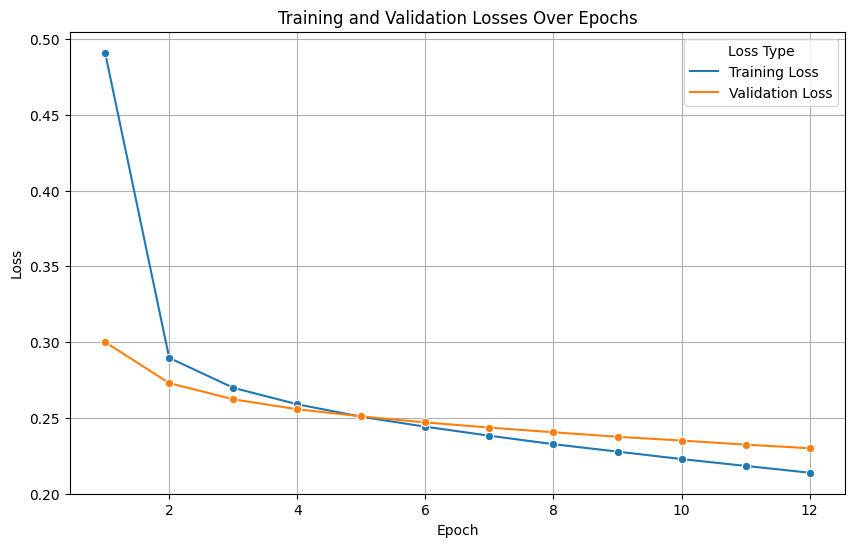

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=losses_df, x="Epoch", y="Loss", hue="Loss Type", marker="o")
plt.title("Training and Validation Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Loss Type")
plt.grid(True)
plt.show()

In [14]:
model_save_path = f"model_weights/model_gen_epoch_{epoch+1}.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to model_weights/model_gen_epoch_12.pth


## Fine Tuned Accuracies

In [15]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model_wgts = torch.load("model_weights/model_gen_epoch_12.pth")
model.load_state_dict(model_wgts)

<All keys matched successfully>

In [16]:
val_accuracy = evaluate_model(valid, model, tokenizer, device, True)
test_accuracy = evaluate_model(test, model, tokenizer, device)
print("validation accuracy", val_accuracy)
print("testing accuracy", test_accuracy)

input text for generation: [START] deep sea animals live deep in the ocean Frilled sharks and angler fish live far beneath the surface of the ocean, which is why they are known as [A] Deep sea animals [B] fish [C] Long Sea Fish [D] Far Sea Animals [ANSWER]
generated answer: [START] deep sea animals live deep in the ocean Frilled sharks and angler fish live far beneath the surface of the ocean, which is why they are known as [A] Deep sea animals [B] fish [C] Long Sea Fish [D] Far Sea Animals [ANSWER] D Far Sea Animals
actual answer: A Deep sea animals
input text for generation: [START] a beak is used for catching prey by some birds A pelican is hungry, so decides to try to catch some fish. In order to do this, the pelican will [A] use the back of its head [B] use the bottom of its stomach [C] use the front of its face [D] use the back of its tail [ANSWER]
generated answer: [START] a beak is used for catching prey by some birds A pelican is hungry, so decides to try to catch some fish. I

* GPT2 model performs much worse.
* GPT-2 is designed primarily for language generation tasks. It focuses on generating the next token in a sequence based on the preceding tokens, making it highly suitable for text generation.
* GPT-2 is trained with a language modeling objective, which aims to predict the next word in a sequence. This objective does not explicitly involve understanding and discriminating among classes.
* GPT-2 generates sequences token by token, which can introduce errors due to exposure bias. This is why we're seeing much poorer accuracy than BERT.
* For multiple-choice tasks, BERT can be fine-tuned with a classification head specifically designed to discriminate between multiple options, which makes it far-suited.

## Zero-Shot Accuracies

In [8]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

In [10]:
model.eval()
val_accuracy = evaluate_zero_shot_model(valid, model, tokenizer, device, BATCH_SIZE)
test_accuracy = evaluate_zero_shot_model(test, model, tokenizer, device, BATCH_SIZE)
print("validation accuracy", val_accuracy)
print("testing accuracy", test_accuracy)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

validation accuracy 0.002
testing accuracy 0.0


* Which is why we're seeing terrible zero-shot accuracies.
* The model hasn't really learned anything in this case.